In [1]:
import localized_narratives
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle as pkl
from scipy.spatial import ConvexHull
from matplotlib.path import Path

<h1>Step 0: Visualise Dataset</h1>

<h3>I) Get Localized Narratives (ADE20k)</h3>

In [2]:
"""https://github.com/google/localized-narratives/blob/master/demo.py"""

# This folder is where you would like to download the annotation files to and
# where to read them from.
local_dir = os.getcwd()

# The DataLoader class allows us to download the data and read it from file.
data_loader = localized_narratives.DataLoader(local_dir)

# Downloads the annotation files (it first checks if they are not downloaded).
data_loader.download_annotations('ade20k_val')

# Iterates through all or a limited number of (e.g. 1 in this case) annotations
# for all files found in the local folder for a given dataset and split. E.g.
# for `open_images_train` it will read only one shard if only one file was
# downloaded manually.
loc_narr = next(data_loader.load_annotations('ade20k_val', 1))

print(f'\nLocalized Narrative sample:\n{loc_narr}')

print(f'\nVoice recording URL:\n {loc_narr.voice_recording_url}\n')

Already downloaded: ade20k_validation_localized_narratives.jsonl

Localized Narrative sample:
{
 dataset_id: ADE20k,
 image_id: ADE_val_00000175,
 annotator_id: 125,
 caption: In this image on the left side I can see a bed and a window....,
 timed_caption: [{'utterance': 'In', 'start_time': 0.0, 'end_time': 0.0}, ...],
 traces: [[{'x': 0.6408, 'y': 0.1371, 't': 0.013}, ...], ...],
 voice_recording: ade20k_validation/ade20k_validation_ADE_val_00000175_125.ogg
}

Voice recording URL:
 https://storage.googleapis.com/localized-narratives/voice-recordings/ade20k_validation/ade20k_validation_0000000000000175_125.ogg



<b>Set paths</b>

In [3]:
image_id = 'ADE_val_00000175'
path_to_image = f'/Volumes/gordonssd/ADE20K_2021_17_01/images/ADE/validation/*/*/{image_id}.jpg'
path_to_image_seg = f'/Volumes/gordonssd/ADE20K_2021_17_01/images/ADE/validation/*/*/{image_id}_seg.png'
path_to_image_json = f'/Volumes/gordonssd/ADE20K_2021_17_01/images/ADE/validation/*/*/{image_id}.json'

<h3>II) Show Image from ADE20k</h3>

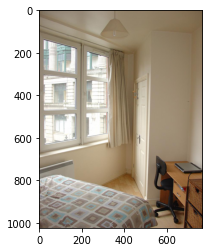

In [4]:
for filename in glob.glob(path_to_image):
    path_to_image = filename

image = mpimg.imread(path_to_image)
plt.imshow(image)
plt.show()

In [5]:
image_height = image.shape[0] #1024
image_width = image.shape[1] #768

<h3>III) Show Image Segmentation from ADE20k

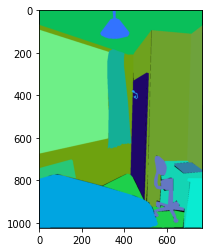

In [6]:
for filename in glob.glob(path_to_image_seg):
    path_to_image_seg = filename
image_seg = mpimg.imread(path_to_image_seg)
plt.imshow(image_seg)
plt.show()

<h3>IV) Convert to Object Labels</h3>

From https://github.com/CSAILVision/ADE20K/blob/main/utils/utils_ade20k.py

In [7]:
from PIL import Image
with Image.open(path_to_image_seg) as io:
        seg = np.array(io);
R = seg[:,:,0];
G = seg[:,:,1];
B = seg[:,:,2];
ObjectClassMasks = (R/10).astype(np.int32)*256+(G.astype(np.int32));
ObjectClassMasks

array([[  0,   0, 447, ..., 447,   0,   0],
       [  0,   0, 447, ..., 447,   0,   0],
       [  0,   0, 447, ..., 447,   0,   0],
       ...,
       [  0,   0, 165, ..., 491, 491,   0],
       [  0,   0, 165, ..., 491, 491,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

<h3>V) Object Name Lookup by Label</h3>

In [8]:
object_id = ObjectClassMasks[900][200] # 'bed' by visual inspection

In [9]:
# Get object name lookup table
with open('/Volumes/gordonssd/ADE20K_2021_17_01/index_ade20k.pkl', 'rb') as f:
    index_ade20k = pkl.load(f)
# Replace "-" with "other"
index_ade20k['objectnames'][0] = "other"

In [10]:
index_ade20k['objectnames'][:5] # only showing first 5

['other',
 'aarm panel',
 'abacus',
 'accordion, piano accordion, squeeze box',
 'acropolis']

In [11]:
# indexing is ahead by one
index_ade20k['objectnames'][object_id - 1]

'bed'

<h1>Step 1: Word-trace alignments and segmentation mask</h1>

<h3>I) Get traces</h3>

In [12]:
# Concatenate all trace segments
import itertools
traces = list(itertools.chain.from_iterable(loc_narr.traces))
traces[:5] # only showing first 5

[{'x': 0.6408, 'y': 0.1371, 't': 0.013},
 {'x': 0.6408, 'y': 0.2455, 't': 0.029},
 {'x': 0.6354, 'y': 0.3292, 't': 0.045},
 {'x': 0.6152, 'y': 0.4101, 't': 0.062},
 {'x': 0.6098, 'y': 0.4897, 't': 0.079}]

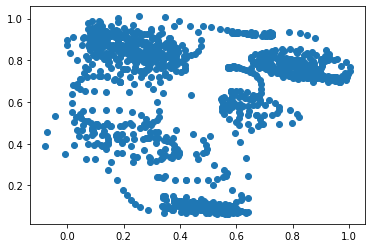

In [13]:
x = [trace['x'] for trace in traces]
y = [trace['y'] for trace in traces]

plt.scatter(x, y)
plt.show()

<h3>II) Align traces to word/phrase</h3>

In [14]:
loc_narr.caption

'In this image on the left side I can see a bed and a window. On right side, I can see some object on the table and a door. At the top I can see the light.'

In [15]:
timed_caption = loc_narr.timed_caption
timed_caption

[{'utterance': 'In', 'start_time': 0.0, 'end_time': 0.0},
 {'utterance': 'this', 'start_time': 0.0, 'end_time': 0.8},
 {'utterance': 'image', 'start_time': 0.8, 'end_time': 1.0},
 {'utterance': 'on', 'start_time': 1.0, 'end_time': 1.4},
 {'utterance': 'the', 'start_time': 1.4, 'end_time': 1.6},
 {'utterance': 'left', 'start_time': 1.6, 'end_time': 2.1},
 {'utterance': 'side', 'start_time': 2.1, 'end_time': 2.3},
 {'utterance': 'I', 'start_time': 2.3, 'end_time': 2.6},
 {'utterance': 'can', 'start_time': 2.6, 'end_time': 3.0},
 {'utterance': 'see', 'start_time': 3.0, 'end_time': 3.3},
 {'utterance': 'a', 'start_time': 3.3, 'end_time': 4.4},
 {'utterance': 'bed', 'start_time': 4.4, 'end_time': 5.2},
 {'utterance': 'and', 'start_time': 5.2, 'end_time': 7.5},
 {'utterance': 'a', 'start_time': 7.5, 'end_time': 7.5},
 {'utterance': 'window.', 'start_time': 7.5, 'end_time': 8.1},
 {'utterance': 'On', 'start_time': 8.1, 'end_time': 11.5},
 {'utterance': 'right', 'start_time': 11.6, 'end_time':

<b>Get list of word_trace_align objects</b>

In [16]:
class word_trace_align:
    word = ''
    start_end = (0.0, 0.8)
    word_traces = [{'x': 0.6408, 'y': 0.1371, 't': 0.013}]
    hull = None
    tag = 'dog'
    
    def __init__(self, w, start_end):
        self.word=w
        self.start_end = start_end

In [17]:
import string
def clean_text(text):
    return text.translate(str.maketrans('', '', string.punctuation)).lower()

In [18]:
clean_text('In this?!')

'in this'

In [19]:
narrative = []

In [20]:
save_word = ''
for word in timed_caption:
    w = save_word + word['utterance']
    w = clean_text(w)
    save_word = ''
    # Check if start_time match end_time
    if (word['start_time']==word['end_time']):
        # Make phrase with next word
        save_word = word['utterance'] + ' '
        continue
    narrative.append(word_trace_align(w, (word['start_time'], word['end_time'])))

In [21]:
for word in narrative:
    print(word.word, word.start_end) 

in this (0.0, 0.8)
image (0.8, 1.0)
on (1.0, 1.4)
the (1.4, 1.6)
left (1.6, 2.1)
side (2.1, 2.3)
i (2.3, 2.6)
can (2.6, 3.0)
see (3.0, 3.3)
a (3.3, 4.4)
bed (4.4, 5.2)
and (5.2, 7.5)
a window (7.5, 8.1)
on (8.1, 11.5)
right (11.6, 12.3)
side (12.3, 12.4)
i (12.4, 12.7)
can (12.7, 13.1)
see (13.1, 13.2)
some (13.2, 16.4)
object (16.4, 16.9)
on (16.9, 17.1)
the table (17.1, 17.3)
and (17.3, 19.6)
a (19.6, 19.7)
door (19.7, 19.9)
at (19.9, 20.6)
the (20.6, 20.8)
top (20.8, 20.9)
i (20.9, 21.2)
can (21.2, 21.5)
see (21.5, 21.7)
the (21.7, 21.9)
light (21.9, 22.2)


<b>Convert (start_time, end_time) to trace coordinates that fall within the time window</b>

In [22]:
for word in narrative:
    start_end = word.start_end
    start_time = start_end[0]
    end_time = start_end[1]
    # Filter trace_seg for items with t value within start_time:end_time
    word.word_traces=list(filter(lambda coord: start_time<=coord['t']<= end_time, traces))

In [23]:
narrative[0].word_traces

[{'x': 0.6408, 'y': 0.1371, 't': 0.013},
 {'x': 0.6408, 'y': 0.2455, 't': 0.029},
 {'x': 0.6354, 'y': 0.3292, 't': 0.045},
 {'x': 0.6152, 'y': 0.4101, 't': 0.062},
 {'x': 0.6098, 'y': 0.4897, 't': 0.079},
 {'x': 0.6098, 'y': 0.524, 't': 0.097},
 {'x': 0.6098, 'y': 0.5542, 't': 0.114},
 {'x': 0.6079, 'y': 0.5775, 't': 0.13},
 {'x': 0.5969, 'y': 0.5912, 't': 0.147},
 {'x': 0.5878, 'y': 0.6008, 't': 0.164},
 {'x': 0.586, 'y': 0.6022, 't': 0.18},
 {'x': 0.5841, 'y': 0.6036, 't': 0.214},
 {'x': 0.5805, 'y': 0.6049, 't': 0.23},
 {'x': 0.575, 'y': 0.6077, 't': 0.247},
 {'x': 0.5476, 'y': 0.6159, 't': 0.264},
 {'x': 0.4378, 'y': 0.6324, 't': 0.28},
 {'x': 0.339, 'y': 0.6434, 't': 0.297},
 {'x': 0.2183, 'y': 0.6461, 't': 0.314},
 {'x': 0.136, 'y': 0.6461, 't': 0.33},
 {'x': 0.0939, 'y': 0.6516, 't': 0.348},
 {'x': 0.0647, 'y': 0.6543, 't': 0.364},
 {'x': 0.0445, 'y': 0.6598, 't': 0.381},
 {'x': 0.0354, 'y': 0.6694, 't': 0.397},
 {'x': 0.0354, 'y': 0.6859, 't': 0.414},
 {'x': 0.0482, 'y': 0.7119

<h3>III) Get convex hull of traces</h3>

In [24]:
for word in narrative:
    points = word.word_traces
    points = np.array([[point['x'], point['y']] for point in points])
    hull = ConvexHull(points)
    word.hull = hull

<h3>IV) Get most frequent label within hull</h3>

In [25]:
def hull_to_name(hull):    
    # make a polygon from the hull verticies
    points = hull.points
    points = np.array([[point[0]*image_width, point[1]*image_height] for point in points])
    tupVerts = [(points[vtx,0], points[vtx,1]) for vtx in hull.vertices]
    p = Path(tupVerts)
    # make a canvas of coordinates corresponding to the image
    x, y = np.meshgrid(np.arange(image_width), np.arange(image_height)) 
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T     
    # get points in image within hull
    grid = p.contains_points(points)
    mask = grid.reshape(image_height,image_width) # now you have a mask with points inside a polygon
    # get labels at those points
    labels_within_hull = mask*ObjectClassMasks
    labels = labels_within_hull[np.nonzero(labels_within_hull)]
    # get count for unique labels
    values, counts = np.unique(labels, return_counts=True)
    # Edge case: some utterances the traces entirely out of the image 
    # if empty set label to 0
    if len(counts)==0:
        return index_ade20k['objectnames'][0] 
    # get most frequent label within hull
    ind = np.argmax(counts)
    label = values[ind]
    # object name lookup with label
    return index_ade20k['objectnames'][label - 1]

In [26]:
for word in narrative:
    hull = word.hull
    word.tag = hull_to_name(hull)

<h3>V) Print word trace alignment</h3>

In [27]:
# for printing with colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [28]:
for word_trace_align in narrative:
    word = word_trace_align.word
    tag = word_trace_align.tag
    # one tag may have multiple words eg. 	person;individual;someone;somebody;mortal;soul
    # taking only first
    tag = tag.split()[0]
    tag = clean_text(tag)
    print(word+'/'+bcolors.OKGREEN + tag + bcolors.ENDC, end =" ")

in this/wall image/bed on/bed the/bed left/bed side/bed i/bed can/bed see/bed a/bed bed/bed and/windowpane a window/windowpane on/windowpane right/desk side/wall i/desk can/desk see/desk some/desk object/desk on/desk the table/desk and/wall a/door door/wall at/curtain the/ceiling top/lamp i/lamp can/lamp see/lamp the/lamp light/lamp 

<h1>Step 2: Compute tf-idf to get $\alpha_{w}$ and $\alpha_{c}$</h1>
<p>Note: $\alpha_{w}$ is an average of $\alpha_{w,d}$ across all documents</p>

Now that we've seen how the baseline tagging is done for one narrative, we can do the same for the others. In the seq-tagging-baseline notebook you may see the concise version of Step One. Previously for the sake of explanation, I have done Steps 2-4 in multiple iterations of a single narrative but in the other notebook those steps are done in a single iteration. Also in the notebook I have created lists for the words and labels in each narrative that will be used for calculating tf-idf. I put the code from that notebook into a python file seq_tagging_baseline in which I have exposed a function `get_documents(num_narratives)` that will allow me to get those lists so that I can calculate the tf-idf in this main notebook. 

In [262]:
from seq_tagging_baseline import get_documents

In [263]:
raw_word_documents, raw_labels_documents = get_documents(10)

Calculating tf-idf in python
https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76

In [334]:
import pandas as pd

In [335]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(raw_word_documents)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [336]:
df.head()

,also,and,are,at,back,background,bag,bathtub,bed,behind,...,two,up,wall,water,we,which,window,windows,with,yellow
0,0.000000,0.208255,0.000000,0.139291,0.000000,0.000000,0.000000,0.000000,0.199404,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.199404,0.0,0.000000,0.000000
1,0.000000,0.088109,0.235726,0.117863,0.198482,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.147617,0.0,0.117863,0.000000,0.000000,0.0,0.000000,0.0,0.168728,0.000000
2,0.000000,0.000000,0.000000,0.056457,0.000000,0.051039,0.000000,0.095074,0.000000,0.000000,...,0.070710,0.0,0.112914,0.000000,0.282838,0.0,0.080822,0.0,0.000000,0.000000
3,0.000000,0.098194,0.131354,0.000000,0.000000,0.000000,0.221202,0.000000,0.376084,0.221202,...,0.000000,0.0,0.131354,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.194833,0.305222,0.000000,0.000000,0.000000,0.123036,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.194833,0.000000,0.0,0.000000,0.0,0.000000,0.229191


CountVectorizer in TfidfVectorizer ignores single characters by default  
https://stackoverflow.com/questions/43601358/empty-vocabulary-for-single-letter-by-countvectorizer

In [339]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
vectors = Pipeline([('count', CountVectorizer(token_pattern = r"(?u)\b\w+\b")), # keep single chars
                  ('tfid', TfidfTransformer())]).fit_transform(raw_word_documents)
feature_names = CountVectorizer(token_pattern = r"(?u)\b\w+\b").fit(raw_word_documents).get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [340]:
df.head()

,a,also,and,are,at,back,background,bag,bathtub,bed,...,two,up,wall,water,we,which,window,windows,with,yellow
0,0.276954,0.000000,0.184636,0.000000,0.123494,0.000000,0.000000,0.000000,0.000000,0.176789,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.176789,0.0,0.000000,0.000000
1,0.255549,0.000000,0.085183,0.227899,0.113949,0.191892,0.000000,0.000000,0.000000,0.000000,...,0.142716,0.0,0.113949,0.000000,0.000000,0.0,0.000000,0.0,0.163126,0.000000
2,0.283327,0.000000,0.000000,0.000000,0.054144,0.000000,0.048947,0.000000,0.091178,0.000000,...,0.067812,0.0,0.108287,0.000000,0.271248,0.0,0.077510,0.0,0.000000,0.000000
3,0.280360,0.000000,0.093453,0.125013,0.000000,0.000000,0.000000,0.210522,0.000000,0.357926,...,0.000000,0.0,0.125013,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.093777,0.179583,0.281331,0.000000,0.000000,0.000000,0.113405,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.179583,0.000000,0.0,0.000000,0.0,0.000000,0.211251


In [341]:
alpha_w_scores = df.mean(0).to_dict()

In [342]:
alpha_w_scores['the']

0.26080934248688264

In [344]:
vectors = vectorizer.fit_transform(raw_labels_documents)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [345]:
alpha_c_scores = df.mean(0).to_dict()

In [346]:
alpha_c_scores['wall']

0.31790345902948713

<h1>Step 3: Use IBM Model 1 to get translation probablities P(w|c) </h1>

In [347]:
from nltk.translate import AlignedSent
from nltk.translate import IBMModel1

https://www.nltk.org/_modules/nltk/translate/ibm1.html

In [348]:
labels_documents = [document.split() for document in raw_labels_documents]
words_documents = [document.split() for document in raw_word_documents]

In [349]:
bitext = []
for i in range(len(words_documents)):
    bitext.append(AlignedSent(words_documents[i], labels_documents[i]))

In [350]:
ibm1 = IBMModel1(bitext, 5)

In [351]:
table = ibm1.translation_table

In [352]:
table_as_df = pd.DataFrame.from_dict(table).fillna(0)
table_as_df.head()

,up,board,glass,blurry,shelves,building,two,mountains,curtain,see,...,speaker,boards,pots,blue,fencing,door,recipes,sink,stand,flower
NaN,7.079083e-07,7.079083e-07,0.000126,0.000074,0.000001,0.000049,0.000998,0.000079,0.000014,0.073586,...,0.000074,0.000014,8.196566e-06,0.000031,4.435499e-05,0.000553,0.000014,0.000001,0.000074,8.196566e-06
building,2.138425e-02,2.138425e-02,0.021379,0.000000,0.000000,0.021382,0.000007,0.000000,0.000000,0.032139,...,0.000000,0.000000,9.950451e-07,0.000000,2.269066e-05,0.000000,0.000000,0.000000,0.000000,9.950451e-07
earth,3.055112e-02,3.055112e-02,0.030544,0.000000,0.000000,0.030548,0.000000,0.000000,0.000000,0.008325,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
wall,0.000000e+00,0.000000e+00,0.000084,0.001247,0.002948,0.000000,0.016336,0.000000,0.000084,0.052740,...,0.001247,0.000084,0.000000e+00,0.000000,1.726748e-07,0.012884,0.000084,0.002948,0.001247,0.000000e+00
counter,0.000000e+00,0.000000e+00,0.069915,0.000000,0.000000,0.000000,0.019140,0.000000,0.069937,0.000000,...,0.000000,0.069937,0.000000e+00,0.000000,0.000000e+00,0.000000,0.069937,0.000000,0.000000,0.000000e+00


In [353]:
# verify that sum of P(w|c) for a given c is 1 for all w
pd.DataFrame.from_dict(table).fillna(0).sum(axis=1)

NaN           1.0
building      1.0
earth         1.0
wall          1.0
counter       1.0
food          1.0
price         1.0
person        1.0
other         1.0
windowpane    1.0
floor         1.0
door          1.0
ceiling       1.0
pane          1.0
bathtub       1.0
rod           1.0
shower        1.0
bottle        1.0
sink          1.0
toilet        1.0
embankment    1.0
sand          1.0
trunk         1.0
tree          1.0
house         1.0
mountain      1.0
plant         1.0
sky           1.0
railing       1.0
path          1.0
sea           1.0
bed           1.0
desk          1.0
curtain       1.0
lamp          1.0
wardrobe      1.0
blanket       1.0
cushion       1.0
painting      1.0
table         1.0
chair         1.0
dtype: float64

<b>TODO: Use Add-1 smoothing</b>

<b>Get emission probabilities $\alpha_w$ * P(w|c)</b>

In [373]:
emission_df = table_as_df.copy()
for column in table_as_df:
    emission_df[column] = emission_df[column] * alpha_w_scores[column] 
emission_df.head()

,up,board,glass,blurry,shelves,building,two,mountains,curtain,see,...,speaker,boards,pots,blue,fencing,door,recipes,sink,stand,flower
NaN,7.480821e-09,1.496164e-08,0.000003,0.000001,1.283829e-08,0.000002,3.836566e-05,0.000002,2.704704e-07,0.011462,...,0.000001,2.704704e-07,1.441891e-07,6.463582e-07,1.036254e-06,0.000020,2.704704e-07,1.283829e-08,0.000004,1.441891e-07
building,2.259781e-04,4.519561e-04,0.000541,0.000000,0.000000e+00,0.000664,2.583078e-07,0.000000,0.000000e+00,0.005006,...,0.000000,0.000000e+00,1.750424e-08,0.000000e+00,5.301159e-07,0.000000,0.000000e+00,0.000000e+00,0.000000,1.750424e-08
earth,3.228490e-04,6.456979e-04,0.000773,0.000000,0.000000e+00,0.000949,0.000000e+00,0.000000,0.000000e+00,0.001297,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
wall,0.000000e+00,0.000000e+00,0.000002,0.000022,2.688028e-05,0.000000,6.277488e-04,0.000000,1.608854e-06,0.008215,...,0.000022,1.608854e-06,0.000000e+00,0.000000e+00,4.034157e-09,0.000455,1.608854e-06,2.688028e-05,0.000066,0.000000e+00
counter,0.000000e+00,0.000000e+00,0.001769,0.000000,0.000000e+00,0.000000,7.355238e-04,0.000000,1.342033e-03,0.000000,...,0.000000,1.342033e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.342033e-03,0.000000e+00,0.000000,0.000000e+00


In [374]:
emission_matrix = emission_df.to_numpy()

In [375]:
emission_matrix

array([[7.48082055e-09, 1.49616411e-08, 3.19924104e-06, ...,
        1.28382914e-08, 3.91198616e-06, 1.44189100e-07],
       [2.25978074e-04, 4.51956147e-04, 5.40808136e-04, ...,
        0.00000000e+00, 0.00000000e+00, 1.75042403e-08],
       [3.22848961e-04, 6.45697922e-04, 7.72638433e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.74959892e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.74959892e-03]])

<h1>Step 4: Find Count(c'->c)</h1>

In [150]:
labels_docs = [["<start>"] + document for document in labels_documents]

In [151]:
df = ""
for i in range(len(labels_docs)):
    doc = labels_docs[i]
    if i==0: # for first iteration
        df = pd.crosstab(pd.Series(doc[:-1], name='from'),
            pd.Series(doc[1:], name='to')) 
    else:
        df2 = pd.crosstab(pd.Series(doc[:-1], name='from'),
                pd.Series(doc[1:], name='to'))
        df = df.add(df2, fill_value=0).fillna(0)  

In [154]:
df.head()

to,bathtub,bed,blanket,bottle,building,ceiling,chair,counter,curtain,cushion,...,shower,sink,sky,table,toilet,tree,trunk,wall,wardrobe,windowpane
from,,,,,,,,,,,,,,,,,,,,,
<start>,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0
bathtub,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
bed,0.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
blanket,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
bottle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<b>Use Add-1 smoothing</b>

In [158]:
smooth = df+1

In [168]:
# normalize
normalized = smooth.div(smooth.sum(axis=1), axis=0)
normalized.head()

to,bathtub,bed,blanket,bottle,building,ceiling,chair,counter,curtain,cushion,...,shower,sink,sky,table,toilet,tree,trunk,wall,wardrobe,windowpane
from,,,,,,,,,,,,,,,,,,,,,
<start>,0.040000,0.020000,0.020000,0.020000,0.040000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.020000,0.020000,0.040000,0.040000,0.020000,0.020000,0.020000,0.100000,0.040000,0.020000
bathtub,0.066667,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,...,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,0.022222,0.088889,0.022222,0.022222
bed,0.018519,0.222222,0.037037,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.037037,...,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.018519,0.037037
blanket,0.023810,0.047619,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,...,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.023810,0.047619,0.023810,0.023810
bottle,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,...,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.024390,0.048780,0.024390,0.024390


In [163]:
transition_matrix = normalized.to_numpy()

In [164]:
transition_matrix

array([[0.04      , 0.02      , 0.02      , ..., 0.1       , 0.04      ,
        0.02      ],
       [0.06666667, 0.02222222, 0.02222222, ..., 0.08888889, 0.02222222,
        0.02222222],
       [0.01851852, 0.22222222, 0.03703704, ..., 0.01851852, 0.01851852,
        0.03703704],
       ...,
       [0.02222222, 0.01481481, 0.00740741, ..., 0.48888889, 0.00740741,
        0.04444444],
       [0.02272727, 0.04545455, 0.02272727, ..., 0.02272727, 0.09090909,
        0.02272727],
       [0.01923077, 0.01923077, 0.01923077, ..., 0.11538462, 0.01923077,
        0.11538462]])

<h1>Step 5: Construct Hidden Markov Model</h1>

https://costalab.org/wp-content/uploads/2017/01/hmm.txt

In [ ]:
Pi = transition_matrix[0,:]# starting probabilities
A = transition_matrix[1:,:]# transmission matrix
seq_tagger_hmm.emissionprob_= # emission matrix    

https://stackoverflow.com/questions/9729968/python-implementation-of-viterbi-algorithm/9730083

In [ ]:
import numpy as np

def viterbi(y, A, B, Pi=None):
    """
    Parameters
    ----------
    y : array (T,)
        Observation state sequence. int dtype.
    A : array (K, K)
        State transition matrix. See HiddenMarkovModel.state_transition  for
        details.
    B : array (K, M)
        Emission matrix. See HiddenMarkovModel.emission for details.
    Pi: optional, (K,)
        Initial state probabilities: Pi[i] is the probability x[0] == i. If
        None, uniform initial distribution is assumed (Pi[:] == 1/K).

    Returns
    -------
    x : array (T,)
        Maximum a posteriori probability estimate of hidden state trajectory,
        conditioned on observation sequence y under the model parameters A, B,
        Pi.
    T1: array (K, T)
        the probability of the most likely path so far
    T2: array (K, T)
        the x_j-1 of the most likely path so far
    """
    # Cardinality of the state space
    K = A.shape[0]
    # Initialize the priors with default (uniform dist) if not given by caller
    Pi = Pi if Pi is not None else np.full(K, 1 / K)
    T = len(y)
    T1 = np.empty((K, T), 'd')
    T2 = np.empty((K, T), 'B')

    # Initilaize the tracking tables from first observation
    T1[:, 0] = Pi * B[:, y[0]]
    T2[:, 0] = 0

    # Iterate throught the observations updating the tracking tables
    for i in range(1, T):
        T1[:, i] = np.max(T1[:, i - 1] * A.T * B[np.newaxis, :, y[i]].T, 1)
        T2[:, i] = np.argmax(T1[:, i - 1] * A.T, 1)

    # Build the output, optimal model trajectory
    x = np.empty(T, 'B')
    x[-1] = np.argmax(T1[:, T - 1])
    for i in reversed(range(1, T)):
        x[i - 1] = T2[x[i], i]

    return x, T1, T2